# [Health Insurance Lead Prediction](https://datahack.analyticsvidhya.com/contest/job-a-thon/?utm_source=auto-email#ProblemStatement)

Evaluation metric for this hackathon is [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype

from scipy import stats

from scipy.stats import pearsonr,spearmanr, boxcox_normmax, chi2_contingency, chi2, f, shapiro, probplot
from scipy.special import boxcox1p

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# import warnings
# warnings.filterwarnings('ignore')

from time import time

### Loading dataset

In [2]:
train = pd.read_csv('train_Df64byy.csv')
test = pd.read_csv('test_YCcRUnU.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (50882, 14)
Testing data shape:  (21805, 13)


In [3]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


### rbind train and test datasets

In [4]:
data = pd.concat([train.drop(columns = 'Response'), test], axis = 0)
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72687 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       72687 non-null  int64  
 1   City_Code                72687 non-null  object 
 2   Region_Code              72687 non-null  int64  
 3   Accomodation_Type        72687 non-null  object 
 4   Reco_Insurance_Type      72687 non-null  object 
 5   Upper_Age                72687 non-null  int64  
 6   Lower_Age                72687 non-null  int64  
 7   Is_Spouse                72687 non-null  object 
 8   Health Indicator         55969 non-null  object 
 9   Holding_Policy_Duration  43833 non-null  object 
 10  Holding_Policy_Type      43833 non-null  float64
 11  Reco_Policy_Cat          72687 non-null  int64  
 12  Reco_Policy_Premium      72687 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 7.8+ MB


### checking %ge of null values

In [6]:
data.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           16718
Holding_Policy_Duration    28854
Holding_Policy_Type        28854
Reco_Policy_Cat                0
Reco_Policy_Premium            0
dtype: int64

In [7]:
round((data.isnull().sum()[data.isnull().sum()!=0]/data.shape[0])*100,2)

Health Indicator           23.0
Holding_Policy_Duration    39.7
Holding_Policy_Type        39.7
dtype: float64

In [8]:
data['Health Indicator'].fillna(data['Health Indicator'].value_counts().idxmax(), inplace = True)
train['Health Indicator'].fillna(train['Health Indicator'].value_counts().idxmax(), inplace = True)

data['Holding_Policy_Duration'].fillna(data['Holding_Policy_Duration'].value_counts().idxmax(), inplace = True)
train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].value_counts().idxmax(), inplace = True)

data['Holding_Policy_Type'].fillna(data['Holding_Policy_Type'].value_counts().idxmax(), inplace = True)
train['Holding_Policy_Type'].fillna(train['Holding_Policy_Type'].value_counts().idxmax(), inplace = True)

### Dropping ID column

In [9]:
train.drop(columns = 'ID', inplace = True)

In [10]:
data['Region_Code'] = data['Region_Code'].astype(str)
train['Region_Code'] = train['Region_Code'].astype(str)

data['Reco_Policy_Cat'] = data['Reco_Policy_Cat'].astype(str)
train['Reco_Policy_Cat'] = train['Reco_Policy_Cat'].astype(str)

# EDA
## univariate analysis

### 1. City_Code - Code for the City of the customers

From the analysis below we can conclude that C1 has the maximum number of customers.

In [11]:
train['City_Code'].unique()

array(['C3', 'C5', 'C24', 'C8', 'C9', 'C1', 'C15', 'C28', 'C27', 'C7',
       'C20', 'C25', 'C4', 'C2', 'C34', 'C10', 'C17', 'C18', 'C16', 'C29',
       'C33', 'C26', 'C19', 'C6', 'C12', 'C13', 'C11', 'C14', 'C22',
       'C23', 'C21', 'C36', 'C32', 'C30', 'C35', 'C31'], dtype=object)

In [12]:
train['City_Code'].nunique()

36

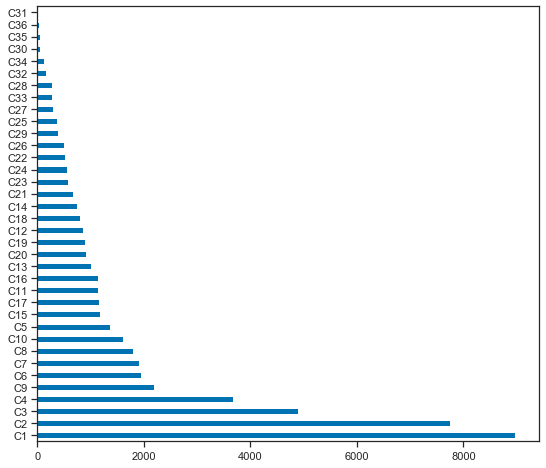

In [13]:
train['City_Code'].value_counts().plot(kind = 'barh');

### 2. Region_Code - Code for the Region of the customers

So region_code 1 has the maximum number of customer and it goes on decreasing. Need to check the reslationship between City_Code and Region_code in bivariate analysis

In [14]:
train['Region_Code'].unique()

array(['3213', '1117', '3732', ..., '5326', '6149', '5450'], dtype=object)

In [15]:
train['Region_Code'].nunique()

5316

In [16]:
train['Region_Code'].value_counts()[:10]

1     96
5     75
6     73
4     73
2     73
10    69
7     64
8     64
16    61
20    58
Name: Region_Code, dtype: int64

### 3. Accomodation_Type - Customer Owns or Rents the house

So majority of the people who applied for insurance own a house

In [17]:
train['Accomodation_Type'].unique()

array(['Rented', 'Owned'], dtype=object)

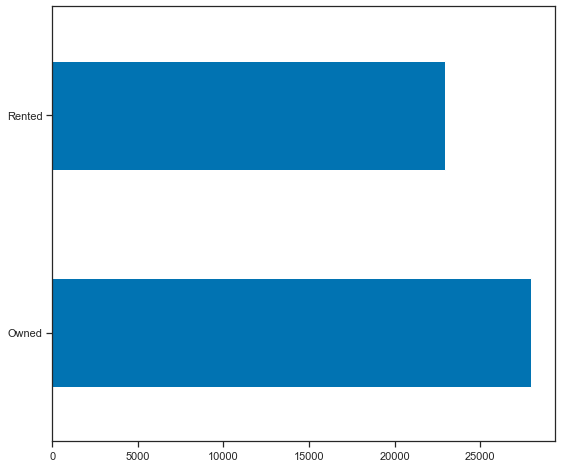

In [18]:
train['Accomodation_Type'].value_counts().plot(kind = 'barh');

### 4. Reco_Insurance_Type - 	Joint or Individual type for the recommended insurance

Majority of the people opt for individual insurance type.

In [19]:
train['Reco_Insurance_Type'].unique()

array(['Individual', 'Joint'], dtype=object)

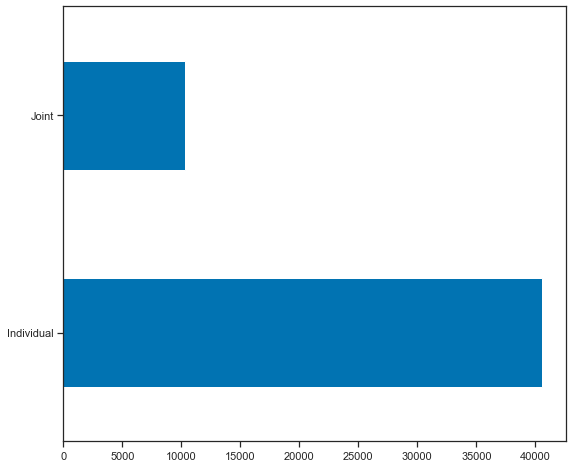

In [20]:
train['Reco_Insurance_Type'].value_counts().plot(kind = 'barh');

### 5. Upper_Age  - Maximum age of the customer 

In [21]:
train['Upper_Age'].describe()

count    50882.000000
mean        44.856275
std         17.310271
min         18.000000
25%         28.000000
50%         44.000000
75%         59.000000
max         75.000000
Name: Upper_Age, dtype: float64

In [61]:
sns.boxplot(data['Upper_Age']);

KeyError: 'Upper_Age'

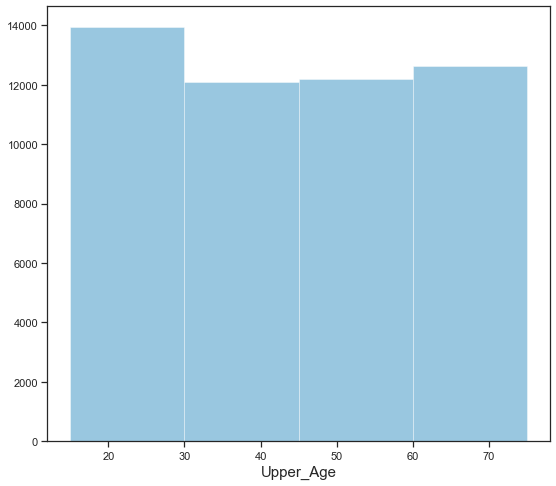

In [22]:
sns.distplot(train['train['Upper_Age']'], kde = False, bins = np.arange(15, 80, 15));
plt.title("Skew: {} | Kurtosis: {}".format(train['Upper_Age'].skew(), train['Upper_Age'].kurt()));

So maximum number of people who apply for insurance are aged between 15 to 30. Followed by 60 to 75.

### 6. Lower _Age - Minimum age of the customer

In [23]:
train['Lower_Age'].describe()

count    50882.000000
mean        42.738866
std         17.319375
min         16.000000
25%         27.000000
50%         40.000000
75%         57.000000
max         75.000000
Name: Lower_Age, dtype: float64

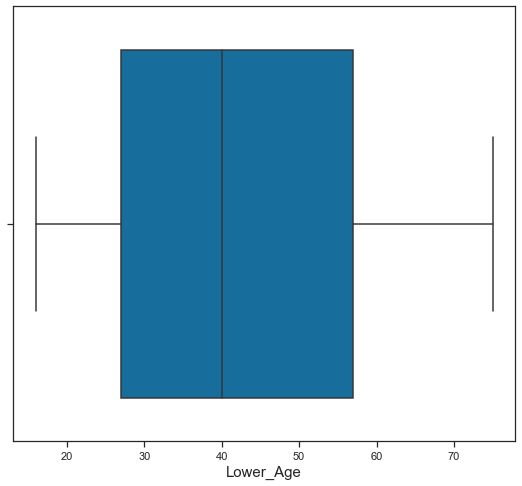

In [62]:
sns.boxplot(data['Lower_Age']);

No outliers present

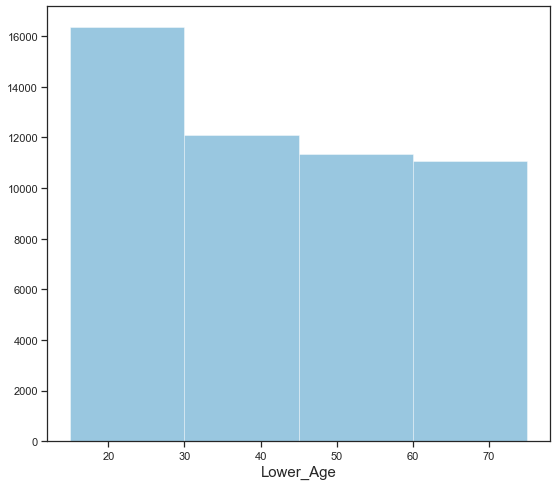

In [24]:
sns.distplot(train['Lower_Age'], kde = False, bins = np.arange(15, 80, 15));

### 7. Is_Spouse - 	If the customers are married to each other (in case of joint insurance) 

So majority of the customers are those who are not married to each other.

In [25]:
train['Is_Spouse'].unique()

array(['No', 'Yes'], dtype=object)

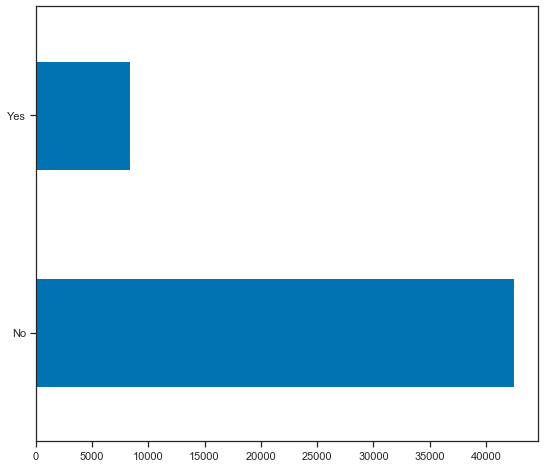

In [26]:
train['Is_Spouse'].value_counts().plot(kind = 'barh');

### 8. Health_Indicator - Encoded values for health of the customer

Filled the null values with the max count value of X1

In [27]:
train['Health Indicator'].unique()

array(['X1', 'X2', 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'], dtype=object)

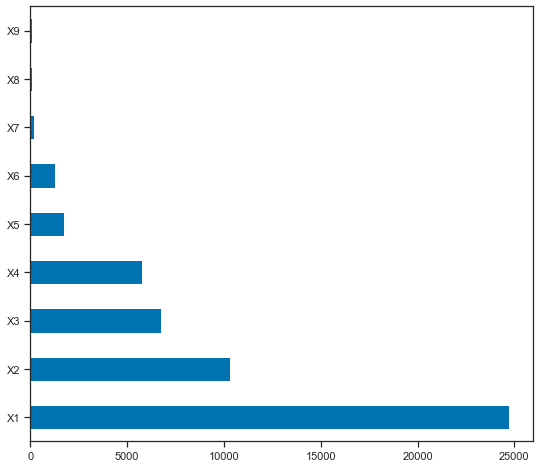

In [28]:
train['Health Indicator'].value_counts(dropna = False).plot(kind = 'barh');

Impute missing values with X1 value as it has the maximum frequency

In [29]:
train.fillna(train['Health Indicator'].value_counts().idxmax(), inplace = True)

In [30]:
data.fillna(train['Health Indicator'].value_counts().idxmax(), inplace = True)

### 9. Holding_Policy_Duration - Duration (in years) of holding policy (a policy that customer has already subscribed to with the company)

In [31]:
data['Holding_Policy_Duration'].unique()

array(['14+', '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0', '11.0',
       '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

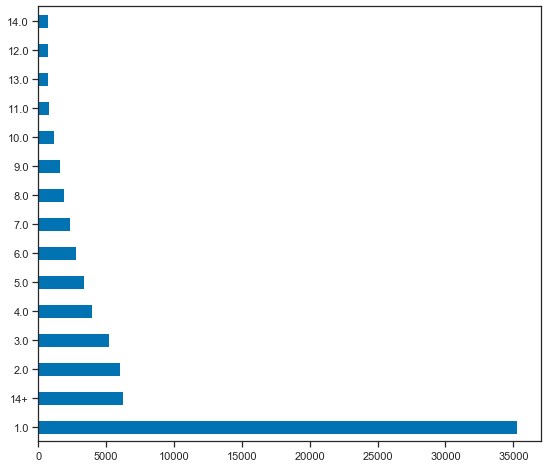

In [32]:
data['Holding_Policy_Duration'].value_counts(dropna = False).plot(kind = 'barh');

### 10. Holding_Policy_Type - Type of holding policy

In [33]:
data['Holding_Policy_Type'].value_counts(dropna=  False)

3.0    47705
1.0    11747
2.0     7155
4.0     6080
Name: Holding_Policy_Type, dtype: int64

In [34]:
train['Holding_Policy_Type'].value_counts(dropna=  False)

3.0    33530
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

### 11. Reco_Policy_Cat - Encoded value for recommended health insurance

In [35]:
data['Reco_Policy_Cat'].value_counts(dropna=  False)

22    9459
18    7890
21    7161
16    5786
17    5445
19    5319
20    4511
12    3127
1     2775
2     2677
14    2512
13    2441
15    2256
3     1550
4     1464
5     1453
6     1181
7     1151
8     1150
9     1146
10    1123
11    1110
Name: Reco_Policy_Cat, dtype: int64

### 12. Reco_Policy_Premium - Annual Premium (INR) for the recommended health insurance

In [36]:
train['Reco_Policy_Premium'].describe()

count    50882.000000
mean     14183.950069
std       6590.074873
min       2280.000000
25%       9248.000000
50%      13178.000000
75%      18096.000000
max      43350.400000
Name: Reco_Policy_Premium, dtype: float64

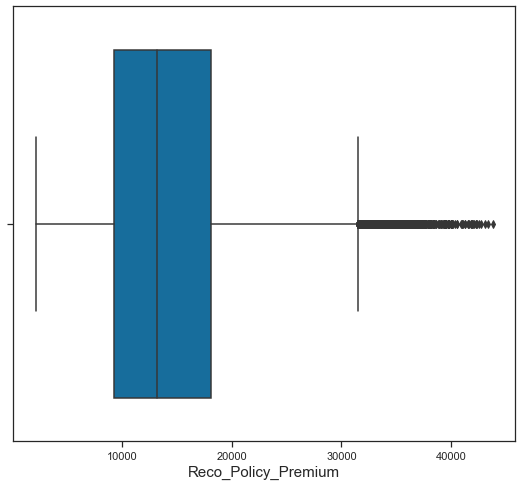

In [63]:
sns.boxplot(data['Reco_Policy_Premium']);

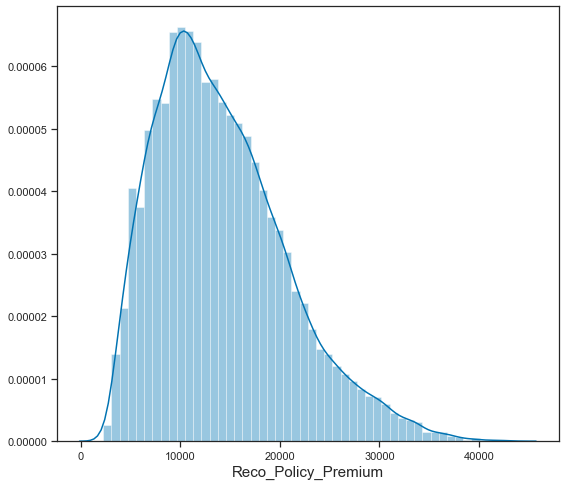

In [37]:
sns.distplot(train['Reco_Policy_Premium'], kde = True);

In [38]:
train['Reco_Policy_Premium'].kurt()

0.4230529912511276

In [39]:
train['Reco_Policy_Premium'].skew()

0.7824628894616024

### 13. Response (Target variable) 0 or 1 

	0 : Customer did not show interest in the recommended policy,
    1 : Customer showed interest in the recommended policy

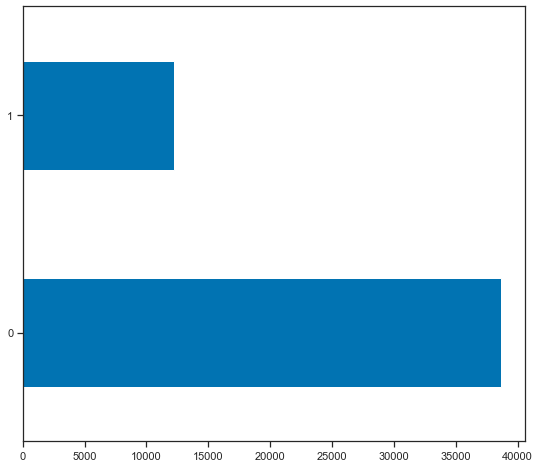

In [40]:
train['Response'].value_counts().plot(kind = 'barh');

So majority of the customers who were approached did not show interest in the insurance.

## Bivariate analysis
1. Continuous and continuous
2. Continuous and categorical
3. categorical and categorical

### 1. Continuous and continuous

#### upper age and lower age

In [41]:
train.loc[:, ['Upper_Age', 'Lower_Age']].head()

,Upper_Age,Lower_Age
0,36,36
1,75,22
2,32,32
3,52,48
4,44,44


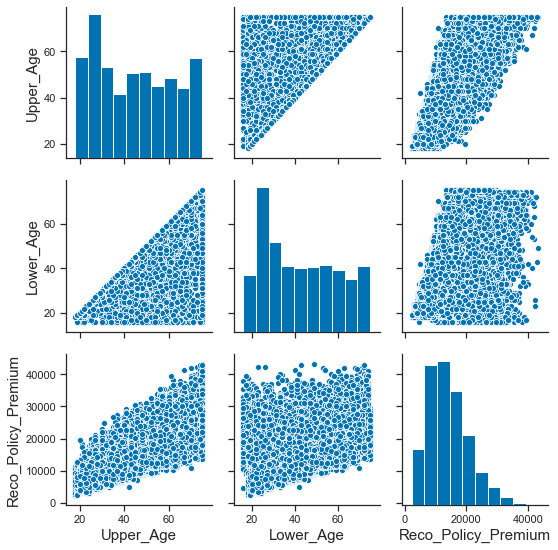

In [42]:
sns.pairplot(train.loc[:, ['Upper_Age', 'Lower_Age','Reco_Policy_Premium']]);

#### Use heatmap to check for multicorrelation

In [43]:
def generate_heatmap(df):
    # Generate a heatmap with the upper triangular matrix masked
    # Compute the correlation matrix
    corr = df.corr(method="spearman")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.figure(figsize = (15,9));
    # Draw the heatmap with the mask 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
    plt.title("Correlation heatmap");
    return

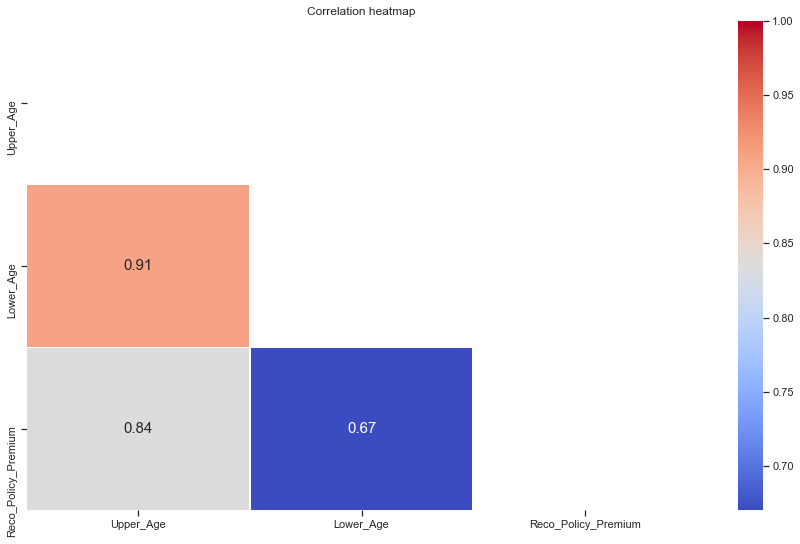

In [44]:
generate_heatmap(train.loc[:, ['Upper_Age', 'Lower_Age','Reco_Policy_Premium']])

In [45]:
train['Upper_Age'].corr(train['Lower_Age'])

0.9213922158232765

As `Upper_Age` and `Lower_Age` has high correlation so to avoid multicolinearity i will be using only `Lower_Age` in the model. And will be dropping `Upper_Age` column.

In [46]:
data.drop(columns = 'Upper_Age', inplace = True)
train.drop(columns = 'Upper_Age', inplace = True)

### 2. Continuous and categorical

In [47]:
train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,22,No,X2,1.0,3.0,22,30510.0,0
2,C5,3732,Owned,Individual,32,No,X1,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,No,X2,3.0,1.0,16,10404.0,0


In [48]:
test = data.iloc[len(train):,:].copy()
print(test.shape)
test.head()

(21805, 12)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,No,X1,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,No,X3,1.0,3.0,5,22534.0


In [49]:
test.dtypes

ID                           int64
City_Code                   object
Region_Code                 object
Accomodation_Type           object
Reco_Insurance_Type         object
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat             object
Reco_Policy_Premium        float64
dtype: object

In [50]:
test_ids =  test.loc[:,['ID']].copy()
test_ids.head()

,ID
0,50883
1,50884
2,50885
3,50886
4,50887


In [51]:
test.drop(columns = 'ID', inplace = True)


# Baseline model

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold

In [53]:
X = train.loc[:, train.columns!= 'Response'].copy()
y = train['Response'].copy()
X.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,C3,3213,Rented,Individual,36,No,X1,14+,3.0,22,11628.0
1,C5,1117,Owned,Joint,22,No,X2,1.0,3.0,22,30510.0
2,C5,3732,Owned,Individual,32,No,X1,1.0,1.0,19,7450.0
3,C24,4378,Owned,Joint,48,No,X1,14+,3.0,19,17780.0
4,C8,2190,Rented,Individual,44,No,X2,3.0,1.0,16,10404.0


In [54]:
X.dtypes

City_Code                   object
Region_Code                 object
Accomodation_Type           object
Reco_Insurance_Type         object
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat             object
Reco_Policy_Premium        float64
dtype: object

### Columns on which one hot encoder will be applied

In [55]:
ohe_dict_cols = {}
for col in data.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(data[col].unique()).to_list()
    
# For one-hot encoder
t_k = []  # nominal column names
t_v = []  # values of nominal columns
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

### 1. Decision tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

# Setup cross validation folds
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle=True)

# initializing classifiers
dt_clf = DecisionTreeClassifier(random_state=0)

colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first', categories = t_v), t_k)], remainder = 'passthrough')

dt_pipeline = Pipeline(steps = [('colt', colT), ("dt", dt_clf)], verbose = False)

scores = cross_val_score(dt_pipeline, X, y, cv = skf, n_jobs = -1,scoring = 'roc_auc')
print('roc_auc scores: ', scores)
print('roc_auc scores mean: {:.3f}'.format(scores.mean()))
print('roc_auc scores std deviation: {:.3f}'.format(scores.std()))

dt_pipeline.fit(X,y)

roc_auc scores:  [0.55948132 0.55790828 0.55737769 0.55194047 0.55157386]
roc_auc scores mean: 0.556
roc_auc scores std deviation: 0.003


Pipeline(memory=None,
         steps=[('colt',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categ_encod',
                                                  OneHotEncoder(categories=[['C3',
                                                                             'C5',
                                                                             'C24',
                                                                             'C8',
                                                                             'C9',
                                                                             'C1',
                                                                             'C15',
                                                                             'C28',
                              

In [57]:
prediction_dt = dt_pipeline.predict(test)

In [58]:
test_ids['Response'] = prediction_dt
test_ids.head()

,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0


In [59]:
test_ids.to_csv('submissions.csv', index = False)

## 2. XGboost

In [ ]:
from xgboost import XGBClassifier

# Setup cross validation folds
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle=True)

# initializing classifiers
xg_clf = XGBClassifier(random_state=0)

colT = ColumnTransformer([
    ('categ_encod', OneHotEncoder(drop = 'first'), ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
                                                   'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
                                                   'Holding_Policy_Type', 'Reco_Policy_Cat'])
], remainder = 'passthrough')

dt_pipeline = Pipeline(steps = [('colt', colT), ("xg", xg_clf)])

In [ ]:
X['Lower_Age'] = X['Lower_Age'].astype(float)

In [ ]:
dt_pipeline.fit(X,y)

In [ ]:
# param_grid = {"dt__max_depth": [3,4,5,6],
#               "dt__max_features": [None, 'auto', 'sqrt', 'log2'],
#               "dt__criterion": ["gini", "entropy"],
#               "dt__min_samples_split": range(6,10)}

# grid = GridSearchCV(dt_pipeline, param_grid, verbose = 0, cv = skf, scoring = 'f1')

# t0 = time()
# grid.fit(X,y)
# print("training time: ", round(time()-t0, 3), "s", sep = '')

# scores = cross_val_score(grid, X, y, cv = skf, scoring = 'f1')
# print('f1-scores: ',scores)
# print("f1-score variance of splits: ",scores.var())
# print("Avg f1-score: ",scores.mean())

# prediction_dt = grid.predict(test)